In [1]:
import os
import glob
import datetime
import pandas as pd

# Map verbose log messages to concise event labels
EVENT_MAPPING = {
    "Signaling robot to start the run.": "run_start",
    "Capture signal received.": "capture_start",
    "Images captured and logged.": "capture_end",
    "Robot signaled run completion.": "run_end",
    "Re-initializing cameras after break.": "reinit_start",
    "Cameras re-initialized and started grabbing.": "reinit_end"
}

# Find and sort all log files in the 'data' folder
log_files = sorted(glob.glob('data/*.txt'))

all_records = []

for path in log_files:
    # Use filename (without .txt) as configuration identifier
    configuration = os.path.splitext(os.path.basename(path))[0]
    records = []
    last_run = None  # Remember the most recent run for reinit events

    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line.startswith("2025"):
                continue

            # Split timestamp from message
            parts = line.split(" - ")
            ts_str, msg = parts[0], parts[-1]
            try:
                dt = datetime.datetime.strptime(ts_str, "%Y-%m-%d %H:%M:%S,%f")
                unix_time = dt.timestamp()
            except ValueError:
                unix_time = None

            # Check for any mapped event in the message
            for phrase, event_label in EVENT_MAPPING.items():
                if phrase in msg:
                    # Attempt to parse run/sample info from the message prefix
                    run = sample = None
                    label = msg.split(":")[0].strip()
                    if label.startswith("Run"):
                        parts_lbl = label.split(",")
                        try:
                            run = int(parts_lbl[0].split()[1])
                        except (IndexError, ValueError):
                            pass
                        if len(parts_lbl) > 1:
                            try:
                                sample = int(parts_lbl[1].split()[1])
                            except (IndexError, ValueError):
                                pass

                    # For reinit events, reuse the last known run if missing
                    if event_label in ("reinit_start", "reinit_end") and run is None:
                        run = last_run

                    record = {
                        "configuration": configuration,
                        "run": run,
                        "sample": sample,
                        "event": event_label,
                        "unix_time": unix_time
                    }
                    records.append(record)

                    # Update last_run when a capture_end is logged
                    if event_label == "capture_end" and run is not None:
                        last_run = run

                    break  # stop checking other phrases once matched

    # Convert this file's records to a DataFrame and display
    df = pd.DataFrame(records)
    print(f"Configuration: {configuration}")
    print(df, "\n")

    all_records.extend(records)

# Combine all log records into one DataFrame
all_df = pd.DataFrame(all_records)

Configuration: 1x1
   configuration  run  sample          event     unix_time
0            1x1    0     NaN      run_start  1.741373e+09
1            1x1    0     0.0  capture_start  1.741373e+09
2            1x1    0     0.0    capture_end  1.741373e+09
3            1x1    0     NaN        run_end  1.741373e+09
4            1x1    0     NaN   reinit_start  1.741373e+09
5            1x1    0     NaN     reinit_end  1.741373e+09
6            1x1    1     NaN      run_start  1.741373e+09
7            1x1    1     0.0  capture_start  1.741373e+09
8            1x1    1     0.0    capture_end  1.741373e+09
9            1x1    1     NaN        run_end  1.741373e+09
10           1x1    1     NaN   reinit_start  1.741373e+09
11           1x1    1     NaN     reinit_end  1.741373e+09
12           1x1    2     NaN      run_start  1.741373e+09
13           1x1    2     0.0  capture_start  1.741373e+09
14           1x1    2     0.0    capture_end  1.741373e+09
15           1x1    2     NaN        

In [2]:
# Prepare lists to collect per-configuration DataFrames
homing_start_dfs = []
capture_length_dfs = []
run_length_dfs = []
reinit_dfs = []
homing_end_dfs = []
total_length_dfs = []
sample_interval_dfs = []
run_interval_dfs = []

for config, group in all_df.groupby('configuration'):
    # 1. Homing Start: time from run_start to first capture_start (sample 0)
    df_run_start = (
        group[group['event'] == 'run_start'][['run', 'unix_time']]
        .groupby('run', as_index=False).min()
    )
    df_capture_start0 = (
        group[(group['event'] == 'capture_start') & (group['sample'] == 0)][['run', 'unix_time']]
        .groupby('run', as_index=False).min()
    )
    hs = pd.merge(df_run_start, df_capture_start0, on='run', suffixes=('_run', '_capture'))
    hs['homing_start_time'] = hs['unix_time_capture'] - hs['unix_time_run']
    hs['configuration'] = config
    homing_start_dfs.append(hs)

    # 2. Capture Length: duration between capture_start and capture_end for each run/sample
    df_cs = (
        group[group['event'] == 'capture_start'][['run', 'sample', 'unix_time']]
        .groupby(['run', 'sample'], as_index=False).min()
    )
    df_ce = (
        group[group['event'] == 'capture_end'][['run', 'sample', 'unix_time']]
        .groupby(['run', 'sample'], as_index=False).min()
    )
    cl = pd.merge(df_cs, df_ce, on=['run', 'sample'], suffixes=('_start', '_end'))
    cl['capture_length'] = cl['unix_time_end'] - cl['unix_time_start']
    cl['configuration'] = config
    capture_length_dfs.append(cl)

    # 3. Reinitialization Duration: time between reinit_start and reinit_end per run
    df_rs = (
        group[group['event'] == 'reinit_start'][['run', 'unix_time']]
        .groupby('run', as_index=False).min()
    )
    df_re = (
        group[group['event'] == 'reinit_end'][['run', 'unix_time']]
        .groupby('run', as_index=False).min()
    )
    rd = pd.merge(df_rs, df_re, on='run', suffixes=('_start', '_end'))
    rd['reinit_duration'] = rd['unix_time_end'] - rd['unix_time_start']
    rd['configuration'] = config
    reinit_dfs.append(rd)

    # 4. Homing End: time from last capture_end to first run_end per run
    df_ce_last = (
        group[group['event'] == 'capture_end'][['run', 'unix_time']]
        .groupby('run', as_index=False).max()
        .rename(columns={'unix_time': 'unix_time_capture_last'})
    )
    df_re_first = (
        group[group['event'] == 'run_end'][['run', 'unix_time']]
        .groupby('run', as_index=False).min()
        .rename(columns={'unix_time': 'unix_time_run_end'})
    )
    he = pd.merge(df_ce_last, df_re_first, on='run')
    he['homing_end_time'] = he['unix_time_run_end'] - he['unix_time_capture_last']
    he['configuration'] = config
    homing_end_dfs.append(he)

    # 5. Run Length: span from first capture_start (sample 0) to last capture_end per run
    rl = pd.merge(df_capture_start0, df_ce_last, on='run')
    rl['run_length'] = rl['unix_time_capture_last'] - rl['unix_time']
    rl['configuration'] = config
    run_length_dfs.append(rl)

    # 6. Total Length: time from run_start to run_end per run
    tl = pd.merge(df_run_start, df_re_first, on='run')
    tl['total_length'] = tl['unix_time_run_end'] - tl['unix_time']
    tl['configuration'] = config
    total_length_dfs.append(tl)

    # 7. Sample-to-Sample Interval: difference between consecutive capture_start times within each run
    cs0 = (
        group[group['event'] == 'capture_start'][['run', 'sample', 'unix_time']]
        .drop_duplicates(['run', 'sample'])
        .sort_values(['run', 'sample'])
    )
    for run_val, run_grp in cs0.groupby('run'):
        run_grp = run_grp.reset_index(drop=True)
        run_grp['prev_time'] = run_grp['unix_time'].shift(1)
        for i in range(1, len(run_grp)):
            interval = run_grp.loc[i, 'unix_time'] - run_grp.loc[i, 'prev_time']
            sample_interval_dfs.append(pd.DataFrame([{
                'configuration': config,
                'run': run_val,
                'interval_label': f"{int(run_grp.loc[i-1,'sample'])}-{int(run_grp.loc[i,'sample'])}",
                'prev_timestamp': run_grp.loc[i-1, 'unix_time'],
                'next_timestamp': run_grp.loc[i, 'unix_time'],
                'time_interval': interval
            }]))

    # 8. Run-to-Run Interval: difference between capture_start times for each sample across runs
    cs_all = (
        group[group['event'] == 'capture_start'][['configuration', 'run', 'sample', 'unix_time']]
        .drop_duplicates(['configuration', 'sample', 'run'])
        .sort_values(['configuration', 'sample', 'run'])
    )
    for (cfg, sample_val), samp_grp in cs_all.groupby(['configuration', 'sample']):
        samp_grp = samp_grp.reset_index(drop=True)
        samp_grp['prev_time'] = samp_grp['unix_time'].shift(1)
        for i in range(1, len(samp_grp)):
            interval = samp_grp.loc[i, 'unix_time'] - samp_grp.loc[i, 'prev_time']
            run_interval_dfs.append(pd.DataFrame([{
                'configuration': cfg,
                'sample': sample_val,
                'interval_label': f"{int(samp_grp.loc[i-1,'run'])}-{int(samp_grp.loc[i,'run'])}",
                'prev_timestamp': samp_grp.loc[i-1, 'unix_time'],
                'next_timestamp': samp_grp.loc[i, 'unix_time'],
                'time_interval': interval
            }]))

# Combine all configurations into unified DataFrames
homing_start_all   = pd.concat(homing_start_dfs,   ignore_index=True)
capture_length_all = pd.concat(capture_length_dfs, ignore_index=True)
run_length_all     = pd.concat(run_length_dfs,     ignore_index=True)
reinit_all         = pd.concat(reinit_dfs,         ignore_index=True)
homing_end_all     = pd.concat(homing_end_dfs,     ignore_index=True)
total_length_all   = pd.concat(total_length_dfs,   ignore_index=True)
sts_interval_all   = pd.concat(sample_interval_dfs,ignore_index=True)
rtr_interval_all   = pd.concat(run_interval_dfs,   ignore_index=True)

# DataFrames

In [3]:
print("All parsed log entries:")
all_df

All parsed log entries:


,configuration,run,sample,event,unix_time
0,1x1,0,NaN,run_start,1.741373e+09
1,1x1,0,0.0,capture_start,1.741373e+09
2,1x1,0,0.0,capture_end,1.741373e+09
3,1x1,0,NaN,run_end,1.741373e+09
4,1x1,0,NaN,reinit_start,1.741373e+09
...,...,...,...,...,...
733,4x8,4,30.0,capture_start,1.741367e+09
734,4x8,4,30.0,capture_end,1.741367e+09
735,4x8,4,31.0,capture_start,1.741367e+09
736,4x8,4,31.0,capture_end,1.741367e+09


In [4]:
print("Homing Start DataFrame:")
homing_start_all

Homing Start DataFrame:


,run,unix_time_run,unix_time_capture,homing_start_time,configuration
0,0,1.741373e+09,1.741373e+09,27.929,1x1
1,1,1.741373e+09,1.741373e+09,27.927,1x1
2,2,1.741373e+09,1.741373e+09,27.919,1x1
3,3,1.741373e+09,1.741373e+09,27.909,1x1
4,4,1.741373e+09,1.741373e+09,27.923,1x1
5,0,1.741372e+09,1.741372e+09,28.979,1x2
6,1,1.741372e+09,1.741372e+09,28.973,1x2
7,2,1.741372e+09,1.741372e+09,28.984,1x2
8,3,1.741372e+09,1.741373e+09,28.975,1x2
9,4,1.741373e+09,1.741373e+09,28.980,1x2


In [5]:
print("Capture Length DataFrame:")
capture_length_all

Capture Length DataFrame:


,run,sample,unix_time_start,unix_time_end,capture_length,configuration
0,0,0.0,1.741373e+09,1.741373e+09,0.040,1x1
1,1,0.0,1.741373e+09,1.741373e+09,0.053,1x1
2,2,0.0,1.741373e+09,1.741373e+09,0.124,1x1
3,3,0.0,1.741373e+09,1.741373e+09,0.046,1x1
4,4,0.0,1.741373e+09,1.741373e+09,0.055,1x1
...,...,...,...,...,...,...
310,4,27.0,1.741367e+09,1.741367e+09,0.049,4x8
311,4,28.0,1.741367e+09,1.741367e+09,0.028,4x8
312,4,29.0,1.741367e+09,1.741367e+09,0.033,4x8
313,4,30.0,1.741367e+09,1.741367e+09,0.051,4x8


In [6]:
print("Run Length DataFrame:")
run_length_all

Run Length DataFrame:


,run,unix_time,unix_time_capture_last,run_length,configuration
0,0,1.741373e+09,1.741373e+09,0.040,1x1
1,1,1.741373e+09,1.741373e+09,0.053,1x1
2,2,1.741373e+09,1.741373e+09,0.124,1x1
3,3,1.741373e+09,1.741373e+09,0.046,1x1
4,4,1.741373e+09,1.741373e+09,0.055,1x1
5,0,1.741372e+09,1.741372e+09,18.652,1x2
6,1,1.741372e+09,1.741372e+09,18.686,1x2
7,2,1.741372e+09,1.741372e+09,18.678,1x2
8,3,1.741373e+09,1.741373e+09,18.695,1x2
9,4,1.741373e+09,1.741373e+09,18.685,1x2


In [7]:
print("Reinitialization Duration DataFrame:")
reinit_all

Reinitialization Duration DataFrame:


,run,unix_time_start,unix_time_end,reinit_duration,configuration
0,0,1.741373e+09,1.741373e+09,0.697,1x1
1,1,1.741373e+09,1.741373e+09,0.664,1x1
2,2,1.741373e+09,1.741373e+09,0.769,1x1
3,3,1.741373e+09,1.741373e+09,0.719,1x1
4,0,1.741372e+09,1.741372e+09,0.649,1x2
5,1,1.741372e+09,1.741372e+09,0.633,1x2
6,2,1.741372e+09,1.741372e+09,0.756,1x2
7,3,1.741373e+09,1.741373e+09,0.720,1x2
8,0,1.741371e+09,1.741371e+09,0.719,2x2
9,1,1.741372e+09,1.741372e+09,0.710,2x2


In [8]:
print("Homing End DataFrame:")
homing_end_all

Homing End DataFrame:


,run,unix_time_capture_last,unix_time_run_end,homing_end_time,configuration
0,0,1.741373e+09,1.741373e+09,10.554,1x1
1,1,1.741373e+09,1.741373e+09,10.562,1x1
2,2,1.741373e+09,1.741373e+09,10.546,1x1
3,3,1.741373e+09,1.741373e+09,10.551,1x1
4,4,1.741373e+09,1.741373e+09,10.544,1x1
5,0,1.741372e+09,1.741372e+09,11.076,1x2
6,1,1.741372e+09,1.741372e+09,11.073,1x2
7,2,1.741372e+09,1.741372e+09,11.072,1x2
8,3,1.741373e+09,1.741373e+09,11.054,1x2
9,4,1.741373e+09,1.741373e+09,11.070,1x2


In [9]:
print("Total Length DataFrame:")
total_length_all

Total Length DataFrame:


,run,unix_time,unix_time_run_end,total_length,configuration
0,0,1.741373e+09,1.741373e+09,38.523,1x1
1,1,1.741373e+09,1.741373e+09,38.542,1x1
2,2,1.741373e+09,1.741373e+09,38.589,1x1
3,3,1.741373e+09,1.741373e+09,38.506,1x1
4,4,1.741373e+09,1.741373e+09,38.522,1x1
5,0,1.741372e+09,1.741372e+09,58.707,1x2
6,1,1.741372e+09,1.741372e+09,58.732,1x2
7,2,1.741372e+09,1.741372e+09,58.734,1x2
8,3,1.741372e+09,1.741373e+09,58.724,1x2
9,4,1.741373e+09,1.741373e+09,58.735,1x2


In [10]:
print("Sample-to-Sample Interval DataFrame:")
sts_interval_all

Sample-to-Sample Interval DataFrame:


,configuration,run,interval_label,prev_timestamp,next_timestamp,time_interval
0,1x2,0,0-1,1.741372e+09,1.741372e+09,18.623
1,1x2,1,0-1,1.741372e+09,1.741372e+09,18.644
2,1x2,2,0-1,1.741372e+09,1.741372e+09,18.637
3,1x2,3,0-1,1.741373e+09,1.741373e+09,18.664
4,1x2,4,0-1,1.741373e+09,1.741373e+09,18.644
...,...,...,...,...,...,...
280,4x8,4,26-27,1.741367e+09,1.741367e+09,18.620
281,4x8,4,27-28,1.741367e+09,1.741367e+09,18.627
282,4x8,4,28-29,1.741367e+09,1.741367e+09,18.583
283,4x8,4,29-30,1.741367e+09,1.741367e+09,18.607


In [11]:
print("Run-to-Run Interval DataFrame:")
rtr_interval_all

Run-to-Run Interval DataFrame:


,configuration,sample,interval_label,prev_timestamp,next_timestamp,time_interval
0,1x1,0.0,0-1,1.741373e+09,1.741373e+09,60.369
1,1x1,0.0,1-2,1.741373e+09,1.741373e+09,60.333
2,1x1,0.0,2-3,1.741373e+09,1.741373e+09,60.502
3,1x1,0.0,3-4,1.741373e+09,1.741373e+09,60.380
4,1x2,0.0,0-1,1.741372e+09,1.741372e+09,120.669
...,...,...,...,...,...,...
247,4x8,30.0,3-4,1.741366e+09,1.741367e+09,661.013
248,4x8,31.0,0-1,1.741364e+09,1.741365e+09,661.101
249,4x8,31.0,1-2,1.741365e+09,1.741365e+09,660.079
250,4x8,31.0,2-3,1.741365e+09,1.741366e+09,660.934


# Heatmap Visualization

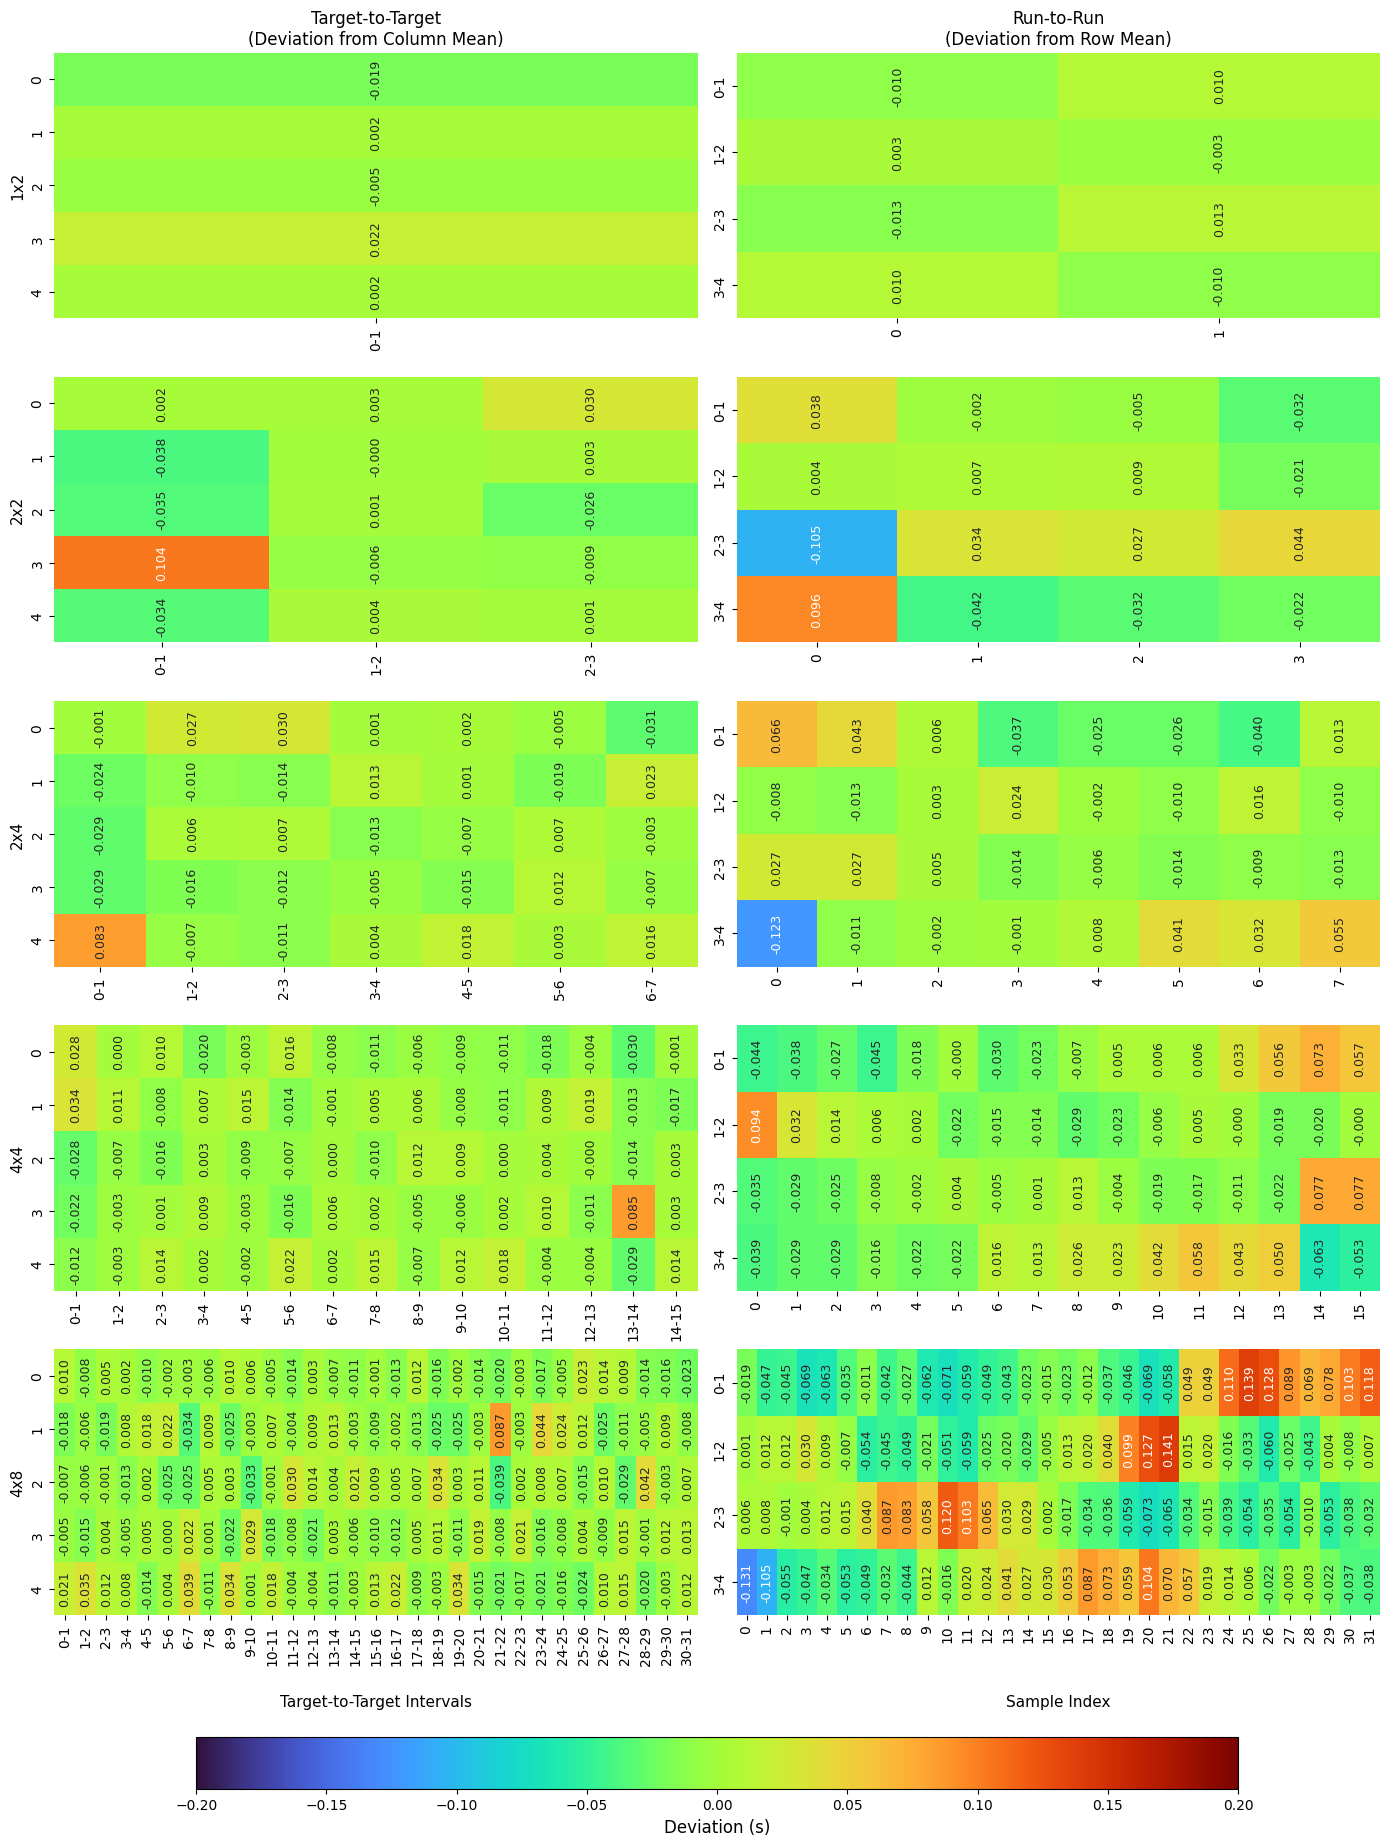

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Configurations to visualize
CONFIGS = ["1x2", "2x2", "2x4", "4x4", "4x8"]

# Color scale settings (±0.2 s deviation)
DEV_RANGE = 0.2
VMIN, VMAX = -DEV_RANGE, DEV_RANGE

# Prepare figure with 5 rows × 2 columns
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
axes[0, 0].set_title("Target-to-Target\n(Deviation from Column Mean)", fontsize=12)
axes[0, 1].set_title("Run-to-Run\n(Deviation from Row Mean)", fontsize=12)

for i, cfg in enumerate(CONFIGS):
    # -----------------------------
    # Left: Target-to-Target heatmap
    # -----------------------------
    ax_tt = axes[i, 0]
    df_tt = (
        sts_interval_all[sts_interval_all['configuration'] == cfg]
        .assign(sample_idx=lambda d: d['interval_label'].str.split('-').str[1].astype(int))
    )
    
    # Pivot: rows=runs, cols=sample intervals (0-1, 1-2, ...)
    pivot_tt = df_tt.pivot_table(
        index='run',
        columns='sample_idx',
        values='time_interval',
        aggfunc='mean'
    )
    # Subtract column means (center by column)
    pivot_tt_dev = pivot_tt - pivot_tt.mean(axis=0)
    pivot_tt_dev.columns = [f"{c-1}-{c}" for c in pivot_tt_dev.columns]
    
    sns.heatmap(
        pivot_tt_dev,
        annot=True, fmt=".3f",
        annot_kws={"rotation": 90, "fontsize": 9},
        cmap="turbo", vmin=VMIN, vmax=VMAX,
        cbar=False, ax=ax_tt
    )
    ax_tt.set_ylabel(cfg, rotation=90, fontsize=11)
    ax_tt.set_xticklabels(ax_tt.get_xticklabels(), rotation=90, ha='center')
    if i == len(CONFIGS) - 1:
        ax_tt.set_xlabel("Target-to-Target Intervals", fontsize=11)
    else:
        ax_tt.set_xlabel("")

    # ---------------------------
    # Right: Run-to-Run heatmap
    # ---------------------------
    ax_rr = axes[i, 1]
    df_rr = (
        rtr_interval_all[rtr_interval_all['configuration'] == cfg]
        .assign(run_idx=lambda d: d['interval_label'].str.split('-').str[1].astype(int))
    )
    
    # Pivot: rows=run intervals (1-2, 2-3, ...), cols=samples
    pivot_rr = df_rr.pivot_table(
        index='run_idx',
        columns='sample',
        values='time_interval',
        aggfunc='mean'
    )
    # Subtract row means (center by row)
    pivot_rr_dev = pivot_rr.sub(pivot_rr.mean(axis=1), axis=0)
    pivot_rr_dev.columns = pivot_rr_dev.columns.astype(int)
    pivot_rr_dev.index = [f"{r-1}-{r}" for r in pivot_rr_dev.index]
    
    sns.heatmap(
        pivot_rr_dev,
        annot=True, fmt=".3f",
        annot_kws={"rotation": 90, "fontsize": 9},
        cmap="turbo", vmin=VMIN, vmax=VMAX,
        cbar=False, ax=ax_rr
    )
    ax_rr.set_xticklabels(ax_rr.get_xticklabels(), rotation=90, ha='center')
    if i == len(CONFIGS) - 1:
        ax_rr.set_xlabel("Sample Index", fontsize=11)
    else:
        ax_rr.set_xlabel("")

# Adjust layout and add shared colorbar
plt.tight_layout(rect=[0, 0, 1, 0.94])
norm = mpl.colors.Normalize(vmin=VMIN, vmax=VMAX)
sm = mpl.cm.ScalarMappable(norm=norm, cmap="turbo")
sm.set_array([])

cbar = fig.colorbar(
    sm, ax=axes.ravel().tolist(),
    orientation="horizontal",
    fraction=0.03, pad=0.07
)
cbar.set_label("Deviation (s)", fontsize=12)

# Align bottom x-axis labels
for ax in axes[-1]:
    ax.xaxis.set_label_coords(0.5, -0.3)

# Save and display
os.makedirs("out", exist_ok=True)
plt.savefig("out/target-run.svg", format="svg", bbox_inches="tight")
plt.show()

# Descriptive Statistics

In [13]:
# Compute descriptive statistics for all computed metrics.

# 1. Homing Start Metrics
homing_start_stats = homing_start_all.groupby('configuration').agg(
	mean_homing_start=('homing_start_time', 'mean'),
	median_homing_start=('homing_start_time', 'median'),
	std_homing_start=('homing_start_time', 'std')
).reset_index()

# 2. Capture Length Metrics
capture_length_stats = capture_length_all.groupby('configuration').agg(
	mean_capture_length=('capture_length', 'mean'),
	median_capture_length=('capture_length', 'median'),
	std_capture_length=('capture_length', 'std')
).reset_index()

# 3. Run Length Metrics
run_length_stats = run_length_all.groupby('configuration').agg(
	mean_run_length=('run_length', 'mean'),
	median_run_length=('run_length', 'median'),
	std_run_length=('run_length', 'std')
).reset_index()

# 4. Reinitialization Duration Metrics
reinit_stats = reinit_all.groupby('configuration').agg(
	mean_reinit=('reinit_duration', 'mean'),
	median_reinit=('reinit_duration', 'median'),
	std_reinit=('reinit_duration', 'std')
).reset_index()

# 5. Homing End Metrics
homing_end_stats = homing_end_all.groupby('configuration').agg(
	mean_homing_end=('homing_end_time', 'mean'),
	median_homing_end=('homing_end_time', 'median'),
	std_homing_end=('homing_end_time', 'std')
).reset_index()

# 6. Total Length Metrics
total_length_stats = total_length_all.groupby('configuration').agg(
	mean_total_length=('total_length', 'mean'),
	median_total_length=('total_length', 'median'),
	std_total_length=('total_length', 'std')
).reset_index()

# 7. Sample-to-Sample Interval Metrics
sts_stats = sts_interval_all.groupby('configuration').agg(
	mean_sts=('time_interval', 'mean'),
	median_sts=('time_interval', 'median'),
	std_sts=('time_interval', 'std')
).reset_index()

# 8. Run-to-Run Interval Metrics
rtr_stats = rtr_interval_all.groupby('configuration').agg(
	mean_rtr=('time_interval', 'mean'),
	median_rtr=('time_interval', 'median'),
	std_rtr=('time_interval', 'std')
).reset_index()

rtr_stats.to_csv('out/rtr_stats.csv', index=False, float_format='%.3f')
sts_stats.to_csv('out/sts_stats.csv', index=False, float_format='%.3f')

# Print the computed descriptive statistics with derivation explanations.
print("Homing Start Metrics\n(time delta between the run_start and the first capture_start for each run):")
display(homing_start_stats)

print("\nCapture Length Metrics\n(time delta between the first capture_start and first capture_end for each run/sample):")
display(capture_length_stats)

print("\nRun Length Metrics\n(time delta between the first capture_start and the last capture_end for each run):")
display(run_length_stats)

print("\nReinitialization Duration Metrics\n(time delta between the reinit_start and the reinit_end for each break):")
display(reinit_stats)

print("\nHoming End Metrics\n(time delta between the last capture_end and the run_end for each run):")
display(homing_end_stats)

print("\nTotal Length Metrics\n(time delta between the run_start and the run_end for each run):")
display(total_length_stats)

print("\nSample-to-Sample Interval Metrics\n(intervals between consecutive capture_start events within each run):")
display(sts_stats)

print("\nRun-to-Run Interval Metrics\n(intervals between capture_start events for the same sample across consecutive runs):")
display(rtr_stats)

Homing Start Metrics
(time delta between the run_start and the first capture_start for each run):


,configuration,mean_homing_start,median_homing_start,std_homing_start
0,1x1,27.9214,27.923,0.007925
1,1x2,28.9782,28.979,0.004324
2,2x2,29.0372,29.037,0.011122
3,2x4,30.7194,30.718,0.005459
4,4x4,31.4114,31.413,0.007733
5,4x8,34.8892,34.887,0.010232



Capture Length Metrics
(time delta between the first capture_start and first capture_end for each run/sample):


,configuration,mean_capture_length,median_capture_length,std_capture_length
0,1x1,0.063600,0.0530,0.034283
1,1x2,0.055300,0.0505,0.020907
2,2x2,0.051500,0.0400,0.036879
3,2x4,0.043600,0.0385,0.020827
4,4x4,0.040362,0.0400,0.016637
5,4x8,0.041519,0.0390,0.015635



Run Length Metrics
(time delta between the first capture_start and the last capture_end for each run):


,configuration,mean_run_length,median_run_length,std_run_length
0,1x1,0.0636,0.053,0.034283
1,1x2,18.6792,18.685,0.016362
2,2x2,55.8976,55.871,0.061060
3,2x4,130.3006,130.279,0.070098
4,4x4,279.1340,279.160,0.048337
5,4x8,576.9288,576.944,0.077735



Reinitialization Duration Metrics
(time delta between the reinit_start and the reinit_end for each break):


,configuration,mean_reinit,median_reinit,std_reinit
0,1x1,0.71225,0.7080,0.044071
1,1x2,0.68950,0.6845,0.058267
2,2x2,0.70525,0.7080,0.013937
3,2x4,0.64825,0.6495,0.006946
4,4x4,0.70150,0.7040,0.026851
5,4x8,0.76550,0.7595,0.071733



Homing End Metrics
(time delta between the last capture_end and the run_end for each run):


,configuration,mean_homing_end,median_homing_end,std_homing_end
0,1x1,10.5514,10.551,0.007127
1,1x2,11.0690,11.072,0.008660
2,2x2,11.2766,11.284,0.011546
3,2x4,12.6048,12.602,0.006723
4,4x4,13.7218,13.721,0.010183
5,4x8,17.2138,17.215,0.012558



Total Length Metrics
(time delta between the run_start and the run_end for each run):


,configuration,mean_total_length,median_total_length,std_total_length
0,1x1,38.5364,38.523,0.032051
1,1x2,58.7264,58.732,0.011675
2,2x2,96.2114,96.180,0.062887
3,2x4,173.6248,173.611,0.066089
4,4x4,324.2672,324.299,0.056896
5,4x8,629.0318,629.051,0.074677



Sample-to-Sample Interval Metrics
(intervals between consecutive capture_start events within each run):


,configuration,mean_sts,median_sts,std_sts
0,1x2,18.642400,18.644,0.014809
1,2x2,18.621333,18.605,0.045299
2,2x4,18.609000,18.604,0.023991
3,4x4,18.606493,18.604,0.019176
4,4x8,18.609471,18.606,0.019849



Run-to-Run Interval Metrics
(intervals between capture_start events for the same sample across consecutive runs):


,configuration,mean_rtr,median_rtr,std_rtr
0,1x1,60.396000,60.3745,0.073462
1,1x2,120.782375,120.7810,0.082169
2,2x2,180.375313,180.3705,0.080458
3,2x4,240.672187,240.6825,0.052991
4,4x4,360.201938,360.1770,0.061891
5,4x8,660.767945,660.9535,0.408364


# Runtime Breakdown

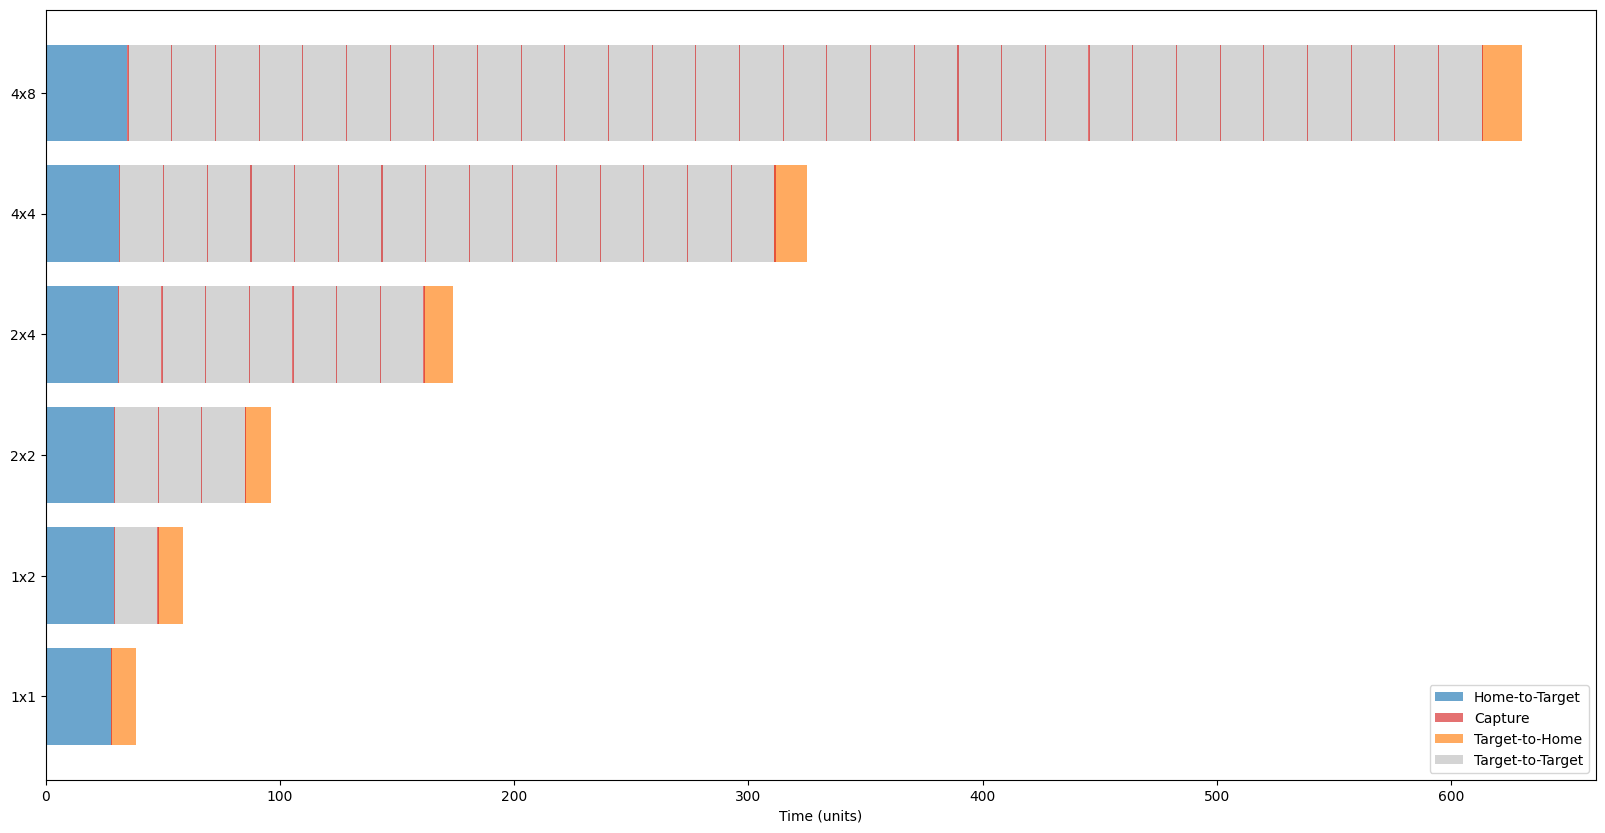

In [14]:
event_colors = {
	"Homing Start": "tab:blue",
	"Capture Time": "tab:red",  # reds remain fully opaque
	"Sample-to-Sample Interval": "tab:gray",
	"Homing End": "tab:orange"
}

mean_homing_start = homing_start_stats.set_index('configuration')['mean_homing_start']
mean_homing_end   = homing_end_stats.set_index('configuration')['mean_homing_end']

mean_capture_time_per_sample = (
    capture_length_all
    .groupby(['configuration', 'sample'])['capture_length']
    .mean()  
)

mean_sts_per_interval = (
    sts_interval_all
    .groupby(['configuration', 'interval_label'])['time_interval']
    .mean()
)

# Set default bar height for non-capture bars and a larger one for capture bars
default_height = 0.8
capture_height = 0.8

fig, ax = plt.subplots(figsize=(20, 10))

configs = sorted(mean_homing_start.index.tolist())

for idx, config in enumerate(configs):
	offset = 0.0
	
	# 1) Homing Start (apply alpha 0.66)
	hs = mean_homing_start.loc[config]
	ax.barh(
		y=idx, width=hs, left=offset,
		color=event_colors["Homing Start"],
		label="Home-to-Target" if idx == 0 else "",
		height=default_height,
		alpha=0.66,
		zorder=1
	)
	offset += hs
	
	# 2) Interleaved capture times and intervals
	if config in mean_capture_time_per_sample.index.levels[0]:
		# Get all samples for this config
		samples = sorted(mean_capture_time_per_sample.loc[config].index.tolist())
		
		for s_i, sample_id in enumerate(samples):
			# (a) Capture time (red; no alpha modification)
			cap_time = mean_capture_time_per_sample.loc[(config, sample_id)]
			capture_y = idx - (capture_height - default_height) / 2
			ax.barh(
				y=capture_y, width=.5, left=offset,
				color=event_colors["Capture Time"],
				label="Capture" if (idx == 0 and s_i == 0) else "",
				height=capture_height,
				alpha=0.66,
				zorder=3
			)
			offset += cap_time
			
			# (b) Interval to next sample, if next sample exists (apply alpha 0.66)
			if sample_id != samples[-1]:
				sample_id_int = int(sample_id)
				interval_label = f"{sample_id_int}-{sample_id_int + 1}"
				interval_time = mean_sts_per_interval.get((config, interval_label), np.nan)
				
				if pd.isna(interval_time):
					print(f"Warning: Interval '{interval_label}' missing for config '{config}'.")
					interval_time = 0
				
				if sample_id == 0 and config == "1x2":
					label_text = "Target-to-Target"
				else:
					label_text = ""

				ax.barh(
					y=idx, width=interval_time, left=offset,
					color=event_colors["Sample-to-Sample Interval"],
					label=label_text,
					height=default_height,
					alpha=0.33,
					zorder=2
				)
				offset += interval_time
	
	# 3) Homing End (apply alpha 0.66)
	he = mean_homing_end.loc[config]
	ax.barh(
		y=idx, width=he, left=offset,
		color=event_colors["Homing End"],
		label="Target-to-Home" if idx == 0 else "",
		height=default_height,
		alpha=0.66,
		zorder=1
	)


# Formatting
ax.set_yticks(range(len(configs)))
ax.set_yticklabels(configs)
ax.set_xlabel('Time (units)')
# ax.set_title('Runtime Breakdown')

# Get current handles and labels from all plotted bars
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles, loc='lower right')

plt.savefig("out/runtime.svg", format="svg", bbox_inches="tight")

plt.show()

In [15]:
total_capture   = mean_capture_time_per_sample.groupby(level=0).sum()     # Σ capture times
total_intervals = mean_sts_per_interval.groupby(level=0).sum()            # Σ intervals

total_avg_run = (
    mean_homing_start
      .add(mean_homing_end,              fill_value=0)
      .add(total_capture,                fill_value=0)
      .add(total_intervals,              fill_value=0)
      .rename('total_avg_run_length')
)

print(total_avg_run.sort_index().to_string(float_format=lambda x: f'{x:>8.2f}'))

configuration
1x1      38.54
1x2      58.80
2x2      96.38
2x4     173.94
4x4     324.88
4x8     630.33


# Analysis

===== Reciprocal linear fit (τ/T0) =====
τ   (s/capture):      19.1814
τ   (s/m²):           479.5350

T0  (s, per run):       19.5510



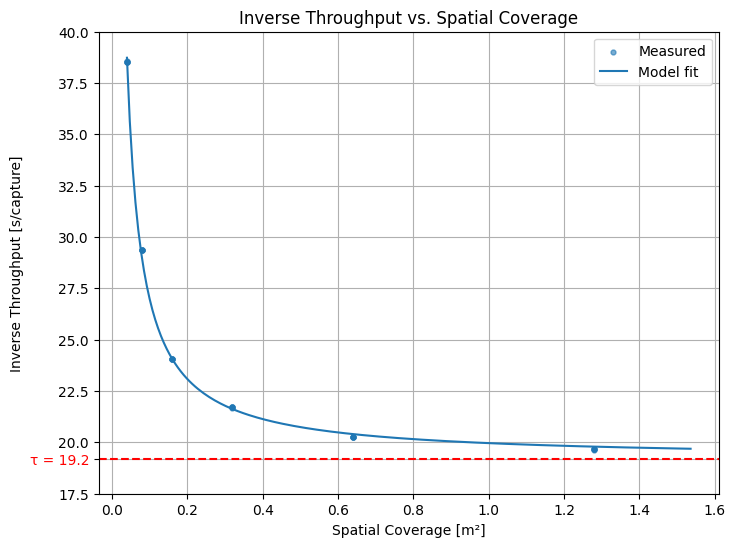

Plot saved to /Users/ozgucbertugcapunaman/Documents/GitHub/MycoRobo3D-DIC/utilities/ThroughputAnalysis/out/time_per_capture_vs_coverage.svg


In [16]:
"""Throughput‑versus‑coverage analysis (tau / T0 notation)

This script fits the reciprocal linear model
    T_capture(x) = τ + (T0·A_c)/x
and reports the fitted parameters using mnemonic names:
    τ   – per‑capture travel‑plus‑exposure time  [s capture⁻¹]
    T0  – fixed once‑per‑run overhead            [s]
All derived area‑normalised forms are printed for completeness.
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FormatStrFormatter

# ---------------------------------------------------------------------------
# 0  Config -----------------------------------------------------------------
# ---------------------------------------------------------------------------

A_C = 0.04  # m² per capture (footprint)
OUT_DIR = Path("out"); OUT_DIR.mkdir(exist_ok=True)

# ---------------------------------------------------------------------------
# 1  Helpers -----------------------------------------------------------------
# ---------------------------------------------------------------------------

def extract_grid_dimensions(cfg: str):
    """Convert a grid string like '3x4' to (rows, cols)."""
    try:
        r, c = map(int, cfg.lower().split("x")); return r, c
    except ValueError:
        return None, None

# ---------------------------------------------------------------------------
# 2  Coverage per configuration --------------------------------------------
# ---------------------------------------------------------------------------

coverage_info = []
for cfg in total_length_all["configuration"].unique():
    rc = extract_grid_dimensions(cfg)
    if rc[0] and rc[1]:
        coverage_info.append({
            "configuration": cfg,
            "coverage_m2": rc[0] * rc[1] * A_C,
        })
coverage_df = pd.DataFrame(coverage_info)

# ---------------------------------------------------------------------------
# 3  Throughput per run ------------------------------------------------------
# ---------------------------------------------------------------------------

cap_count = (
    capture_length_all.groupby(["configuration", "run"]).size().reset_index(name="n_captures")
)
throughput_df = cap_count.merge(
    total_length_all[["configuration", "run", "total_length"]], on=["configuration", "run"]
)
throughput_df["cps"] = throughput_df["n_captures"] / throughput_df["total_length"]
tradeoff = throughput_df.merge(coverage_df, on="configuration")

# ---------------------------------------------------------------------------
# 4  Reciprocal linear fit ---------------------------------------------------
# ---------------------------------------------------------------------------

tradeoff["X"] = 1.0 / tradeoff["coverage_m2"]        # m⁻²
tradeoff["Y"] = 1.0 / tradeoff["cps"]                 # s capture⁻¹

model = LinearRegression().fit(tradeoff[["X"]], tradeoff["Y"])

τ = model.intercept_                     # s / capture
T0A_c = model.coef_[0]                   # s·m² / capture  (= T0 * A_c)
T0 = T0A_c / A_C                         # s overhead per run

τ_per_m2 = τ / A_C                       # s m⁻²
T0_per_m2 = T0 / A_C                     # s m⁻²

# ---------------------------------------------------------------------------
# 5  Console summary ---------------------------------------------------------
# ---------------------------------------------------------------------------

print("===== Reciprocal linear fit (τ/T0) =====")
print(f"τ   (s/capture):      {τ:.4f}")
print(f"τ   (s/m²):           {τ_per_m2:.4f}\n")
print(f"T0  (s, per run):       {T0:.4f}")
print("===========================================\n")

# ---------------------------------------------------------------------------
# 6  Theoretical curve -------------------------------------------------------
# ---------------------------------------------------------------------------

def t_capture_theory(area_m2: np.ndarray, T0A_c_slope: float, τ_val: float):
    cps = area_m2 / (T0A_c_slope + τ_val * area_m2)
    return 1.0 / cps  # s / capture

areas = np.linspace(tradeoff["coverage_m2"].min(), tradeoff["coverage_m2"].max()*1.2, 200)
Tcap_theo = t_capture_theory(areas, T0A_c, τ)

# ---------------------------------------------------------------------------
# 7  Plot --------------------------------------------------------------------
# ---------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(tradeoff["coverage_m2"], tradeoff["Y"], s=50, alpha=0.6, marker=".", label="Measured")
ax.plot(areas, Tcap_theo, linewidth=1.5, label="Model fit")
ax.axhline(y=τ, color="red", linestyle="--")

# annotate τ on y‑axis
τ_tick = float(f"{τ:.1f}")
yticks = sorted(set(ax.get_yticks()) | {τ_tick})
ax.set_yticks(yticks)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.set_yticklabels([f"τ = {y:.1f}" if np.isclose(y, τ_tick) else f"{y:.1f}" for y in yticks])
for label in ax.get_yticklabels():
    if label.get_text().startswith("τ ="):
        label.set_color("red")

ax.set_xlabel("Spatial Coverage [m²]")
ax.set_ylabel("Inverse Throughput [s/capture]")
ax.set_title("Inverse Throughput vs. Spatial Coverage")
ax.legend(); ax.grid(True)

fig_path = OUT_DIR / "time_per_capture_vs_coverage.svg"
plt.savefig(fig_path, bbox_inches="tight")
plt.show()

print(f"Plot saved to {fig_path.resolve()}")
